In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

device = torch.device('mps')
device

device(type='mps')

In [3]:
# transform - 데이터를 텐서로 변환 
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
train_dataset[0][0].squeeze().numpy().shape

(28, 28)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=100) # 100개씩 데이터를 불러옴
test_loader = DataLoader(test_dataset, batch_size=100)

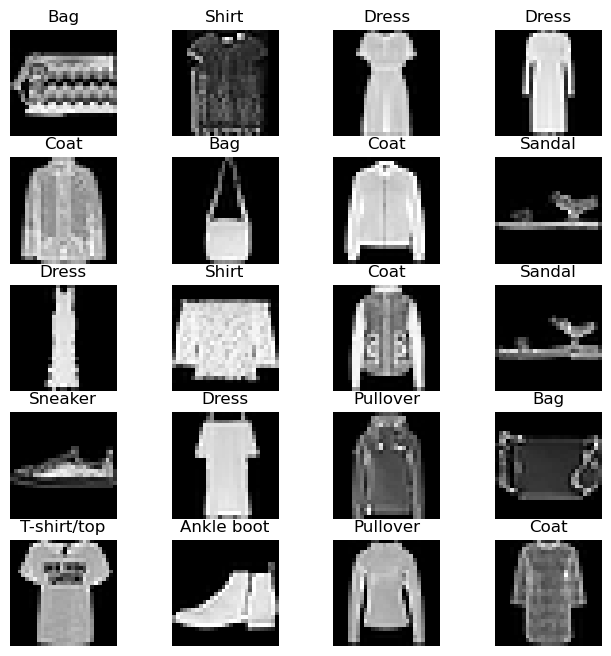

In [6]:
labels_map = {0 : 'T-shirt/top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5

for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0].squeeze() # 1, 28, 28 -> 28, 28
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()


In [14]:
# 합성곱 신경망이 아닌 심층 신경망을 사용하여 학습

class FashionDNN(nn.Module):
    def __init__(self) -> None:
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data:torch.Tensor):
        out = input_data.view(-1, 784)
        out = F.relu6(self.fc1(out))
        out = self.drop(out)
        out = F.relu6(self.fc2(out))
        out = self.fc3(out)
        return out


model = FashionDNN()
model.to(device)
model

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
# 모델 학습
lr = 0.001
criterion = nn.CrossEntropyLoss() # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 5
count = 0

loss_lst = []
iter_lst = []
acc_lst = []

pred_lst = []
labels_lst = []

for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        imgs,labels = imgs.to(device), labels.to(device)

        train = Variable(imgs.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                labels_lst.append(labels)
                test = Variable(imgs.view(100, 1, 28, 28))
                outputs = model(test)
                pred = torch.max(outputs, 1)[1].to(device)
                pred_lst.append(pred)
                correct += (pred == labels).sum()
                total += len(labels)
            
            acc = correct * 100 / total
            loss_lst.append(loss.data)
            iter_lst.append(count)
            acc_lst.append(acc)
        
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {acc}")

Iteration: 500, Loss: 0.629956841468811, Accuracy: 85.35000610351562
Iteration: 1000, Loss: 0.3259488642215729, Accuracy: 85.7800064086914
Iteration: 1500, Loss: 0.32006770372390747, Accuracy: 85.6300048828125
Iteration: 2000, Loss: 0.35881587862968445, Accuracy: 85.60000610351562
Iteration: 2500, Loss: 0.23552992939949036, Accuracy: 86.20000457763672
Iteration: 3000, Loss: 0.2595367431640625, Accuracy: 86.4000015258789


In [7]:
# 합성곱 신경망

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # 일렬로 펴주기
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = FashionCNN()
model.to(device)
model

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [8]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 5
count = 0

loss_lst = []
iter_lst = []
acc_lst = []

pred_lst = []
labels_lst = []

for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        train = Variable(imgs)
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                labels_lst.append(labels)
                test = Variable(imgs)
                outputs = model(test)
                pred = torch.max(outputs, 1)[1].to(device)
                pred_lst.append(pred)
                correct += (pred == labels).sum()
                total += len(labels)
            
            acc = correct * 100 / total
            loss_lst.append(loss.data)
            iter_lst.append(count)
            acc_lst.append(acc)
        
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {acc}")
            

Iteration: 500, Loss: 0.47862598299980164, Accuracy: 88.4800033569336
Iteration: 1000, Loss: 0.2834702134132385, Accuracy: 87.87000274658203
Iteration: 1500, Loss: 0.3127710223197937, Accuracy: 88.50000762939453
Iteration: 2000, Loss: 0.2058054655790329, Accuracy: 89.0300064086914
Iteration: 2500, Loss: 0.11944931745529175, Accuracy: 90.20000457763672
Iteration: 3000, Loss: 0.15965433418750763, Accuracy: 90.30000305175781
